# Laboratory Exercise 2 - Starter (2 points)

In this assignment, you will build a model to predict whether a customer canceled their reservation using the provided `hotel_booking.csv` dataset.

Your tasks are as follows:

1. Perform Exploratory Data Analysis (EDA) to understand the dataset.
2. Preprocess the data to prepare it for modeling.
3. Train and evaluate a machine learning model to predict  whether a customer canceled their reservation.

**Notes:**

- Some parts of the code are already provided. **Do not modify the existing code.**
- **Do not hard-code** any values or test data. There are hidden tests that will check your implementation.
- Write your solution only in the sections marked with `### YOUR SOLUTION`.
- Each task description indicates whether it is **automatically** or **manually graded**.
- You can verify automatically graded tasks using the cell labeled `### TEST` after each function.

***IMPORTANT NOTE:***
- Name your Jupyter Notebook as `lab_ex_2_{index}.ipynb`.
- For example, if your index is 123456, you should name your notebook as `lab_ex_2_12346.ipynb`.

In [45]:
import os
import hashlib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer  # <- required
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


In [46]:
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

RANDOM_STATE = 42

In [47]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [48]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [49]:
df = pd.read_csv("hotel_bookings.csv")

In [28]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,no,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,NaN,NaN,Transient,0,0
1,Resort Hotel,no,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,NaN,NaN,Transient,0,0
2,Resort Hotel,no,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,NaN,NaN,Transient,0,0
3,Resort Hotel,no,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,304.0,NaN,Transient,0,0
4,Resort Hotel,no,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,240.0,NaN,Transient,0,1


In [29]:
### MANUALLY GRADED TASK
def calculate_descriptive_statistics(df):
    """
    Compute the descriptive statistics for all numeric columns in the dataset.
    The statistics should include: count, mean, standard deviation (std), minimum,
    25th percentile, median, 75th percentile, and maximum.

    Return the result as a `pd.DataFrame.
    """

    desc = df.describe()
    return desc

In [30]:
calculate_descriptive_statistics(df)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,0.062518,0.571363
std,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,0.245291,0.792798
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,0.000000
50%,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,0.000000
75%,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,1.000000
max,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,8.000000,5.000000


In [31]:
### MANUALLY GRADED TASK
def plot_pairwise_relationships(df):
    """
    Create pairwise plots to visualize the relationships between all numerical variables
    in the dataset using scatter plots and histograms.
    """

    sns.pairplot(df)


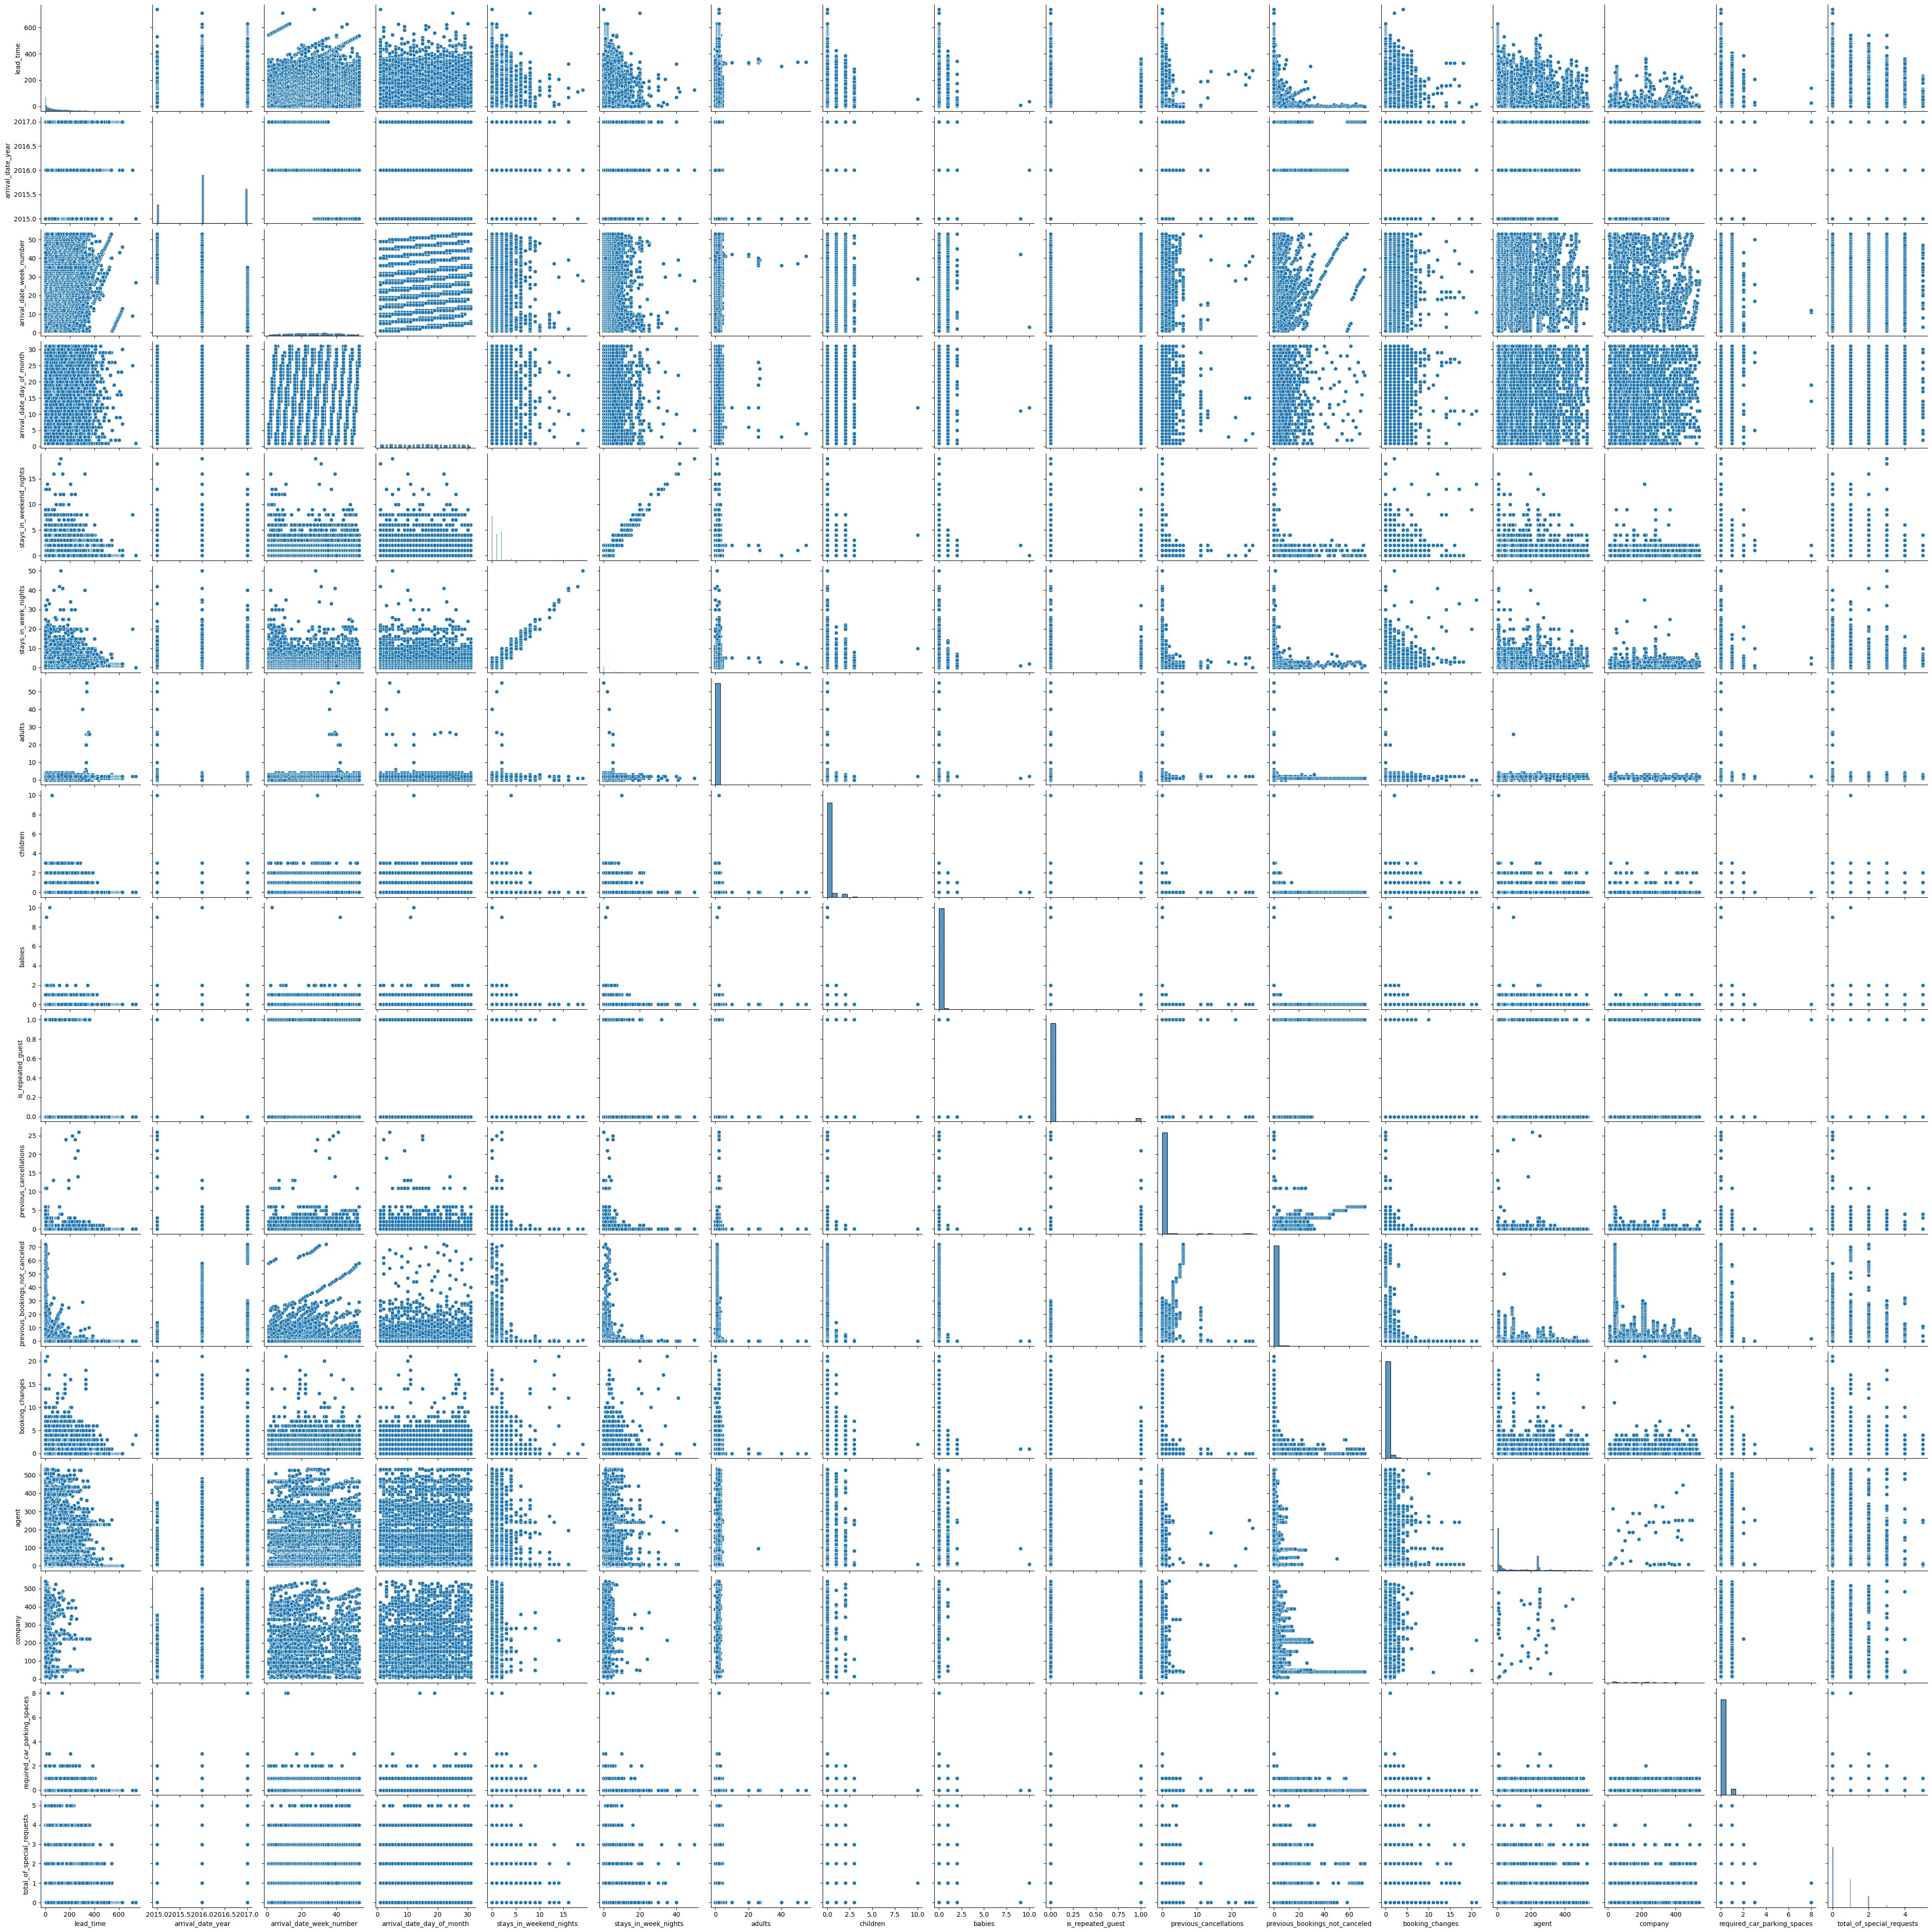

In [32]:
plot_pairwise_relationships(df)

In [33]:
### MANUALLY GRADED TASK
def plot_correlation_intensity(df):
    """
    Plot a heatmap showing the strength and direction of the Pearson correlation
    between all numeric variables in the dataset.
    """

    sns.heatmap(df.corr(numeric_only=True), annot=True)

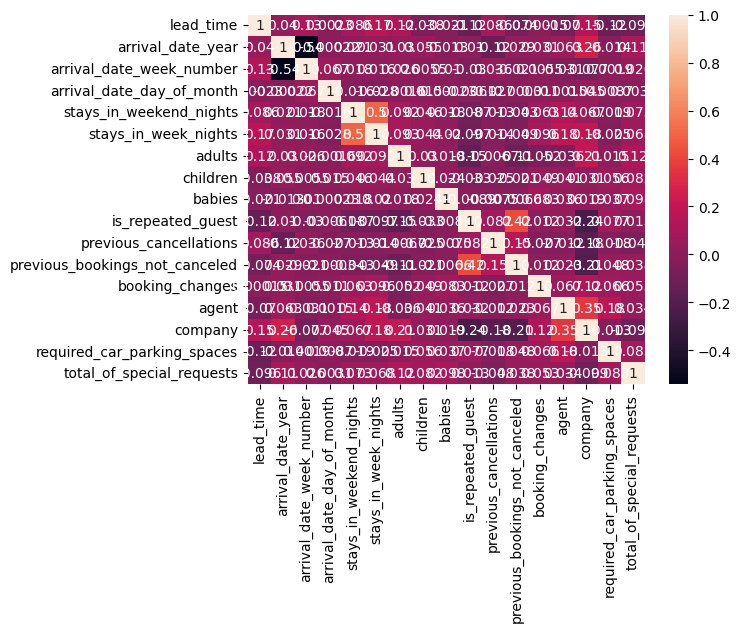

In [34]:
plot_correlation_intensity(df)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [36]:
### MANUALLY GRADED TASK
def plot_lead_time_boxplot(df):
    """
    Create a boxplot showing how lead time differs between canceled and non-canceled bookings.
    """

    sns.boxplot(df, x="is_canceled", y="lead_time")

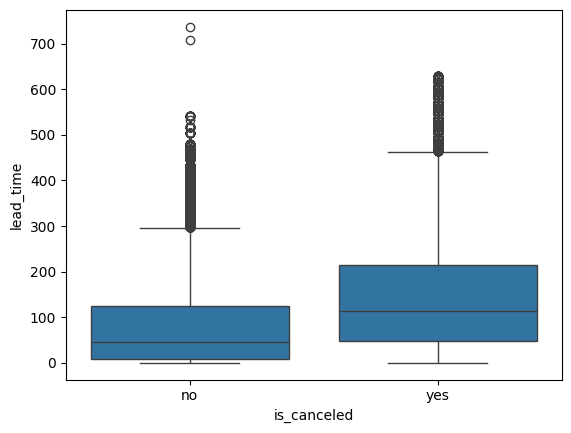

In [37]:
plot_lead_time_boxplot(df)

In [38]:
### MANUALLY GRADED TASK
def plot_cancellation_counts(df):
    """
    Create a bar plot showing how many bookings were canceled vs not canceled.
    """

    count = df["is_canceled"].value_counts().reset_index()
    count.columns = ["is_canceled", "count"]

    sns.barplot(data = count, x="is_canceled", y="count")

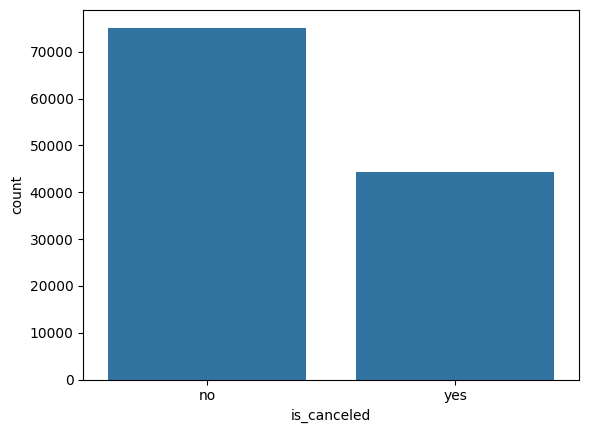

In [39]:
plot_cancellation_counts(df)

In [50]:
### AUTOMATICALLY GRADED TASK
def impute_children_mode(df):
    """
    Fill missing values in `children` with the mode. Use the fillna() method.

    Return the updated dataset as `pd.DataFrame`.
    """
    most_frequent_imputer = SimpleImputer(strategy="most_frequent")
    df[["children"]] = most_frequent_imputer.fit_transform(df[["children"]])


    return df

In [51]:
impute_children_mode(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,no,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,NaN,NaN,Transient,0,0
1,Resort Hotel,no,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,NaN,NaN,Transient,0,0
2,Resort Hotel,no,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,NaN,NaN,Transient,0,0
3,Resort Hotel,no,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,304.0,NaN,Transient,0,0
4,Resort Hotel,no,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,240.0,NaN,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,no,23,2017,August,35,30,2,5,2,...,0,A,A,0,No Deposit,394.0,NaN,Transient,0,0
119386,City Hotel,no,102,2017,August,35,31,2,5,3,...,0,E,E,0,No Deposit,9.0,NaN,Transient,0,2
119387,City Hotel,no,34,2017,August,35,31,2,5,2,...,0,D,D,0,No Deposit,9.0,NaN,Transient,0,4
119388,City Hotel,no,109,2017,August,35,31,2,5,2,...,0,A,A,0,No Deposit,89.0,NaN,Transient,0,0


In [52]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = impute_children_mode(_df)
assert hash_data_frame(_df) == "2f1c5dfe0828d78ea1a8f9c5976821a9a3eaca07cfe98326304d5972c11b361b"

In [53]:
### AUTOMATICALLY GRADED TASK
def impute_country_mode(df):
    """
    Fill missing values in `country` with the mode. Use the fillna() method.

    Return the updated dataset as `pd.DataFrame`.
    """

    most_frequent_imputer = SimpleImputer(strategy="most_frequent")
    df[["country"]] = most_frequent_imputer.fit_transform(df[["country"]])



    return df

In [54]:
impute_country_mode(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,no,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,NaN,NaN,Transient,0,0
1,Resort Hotel,no,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,NaN,NaN,Transient,0,0
2,Resort Hotel,no,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,NaN,NaN,Transient,0,0
3,Resort Hotel,no,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,304.0,NaN,Transient,0,0
4,Resort Hotel,no,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,240.0,NaN,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,no,23,2017,August,35,30,2,5,2,...,0,A,A,0,No Deposit,394.0,NaN,Transient,0,0
119386,City Hotel,no,102,2017,August,35,31,2,5,3,...,0,E,E,0,No Deposit,9.0,NaN,Transient,0,2
119387,City Hotel,no,34,2017,August,35,31,2,5,2,...,0,D,D,0,No Deposit,9.0,NaN,Transient,0,4
119388,City Hotel,no,109,2017,August,35,31,2,5,2,...,0,A,A,0,No Deposit,89.0,NaN,Transient,0,0


In [55]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = impute_country_mode(_df)
assert hash_data_frame(_df) == "528991530f1e5408a3bcbcf681a1c62189e516366e6a767ce163320e705487e5"

In [56]:
### MANUALLY GRADED TASK
def impute_agent_company_knn(df):
    """
    Impute missing values in `agent` and `company` using KNNImputer with the appropriate columns.

    Note: The imputed values should be converted to integer.

    Return the updated dataset as `pd.DataFrame`.
    """

    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_data = knn_imputer.fit_transform(df[["agent","company"]])
    df[["agent", "company"]] = imputed_data.astype(int)



    return df


In [57]:
impute_agent_company_knn(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,no,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,Transient,0,0
1,Resort Hotel,no,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,Transient,0,0
2,Resort Hotel,no,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,Transient,0,0
3,Resort Hotel,no,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,Transient,0,0
4,Resort Hotel,no,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,no,23,2017,August,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,Transient,0,0
119386,City Hotel,no,102,2017,August,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,Transient,0,2
119387,City Hotel,no,34,2017,August,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,Transient,0,4
119388,City Hotel,no,109,2017,August,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,Transient,0,0


In [70]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_hotel(df):
    """
    Encode the `hotel` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.

    Return the updated dataset as `pd.DataFrame`.
    """
    if "hotel" in df.columns:
      print(df["hotel"].value_counts())
      one_hot_encoded_values = pd.get_dummies(df["hotel"])
      df = df.drop(columns = ["hotel"])
      df = pd.concat([df, one_hot_encoded_values], axis=1)

    return df


In [71]:
encode_or_drop_hotel(df)

hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests,City Hotel,Resort Hotel
0,no,342,2015,July,27,1,0,0,2,0.0,...,C,3,No Deposit,86,189,Transient,0,0,False,True
1,no,737,2015,July,27,1,0,0,2,0.0,...,C,4,No Deposit,86,189,Transient,0,0,False,True
2,no,7,2015,July,27,1,0,1,1,0.0,...,C,0,No Deposit,86,189,Transient,0,0,False,True
3,no,13,2015,July,27,1,0,1,1,0.0,...,A,0,No Deposit,304,100,Transient,0,0,False,True
4,no,14,2015,July,27,1,0,2,2,0.0,...,A,0,No Deposit,240,255,Transient,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,no,23,2017,August,35,30,2,5,2,0.0,...,A,0,No Deposit,394,405,Transient,0,0,True,False
119386,no,102,2017,August,35,31,2,5,3,0.0,...,E,0,No Deposit,9,212,Transient,0,2,True,False
119387,no,34,2017,August,35,31,2,5,2,0.0,...,D,0,No Deposit,9,212,Transient,0,4,True,False
119388,no,109,2017,August,35,31,2,5,2,0.0,...,A,0,No Deposit,89,50,Transient,0,0,True,False


In [72]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_or_drop_hotel(_df)
assert hash_data_frame(_df) == "ddfef26391e08ec0e788486481c885ebeecda826fa125e665e4eeea6096b91c9"

hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


AssertionError: 

In [73]:
### AUTOMATICALLY GRADED TASK
def encode_is_canceled(df):
    """
    Encode the `is_canceled` column manually:
    - "no"  -> 0
    - "yes" -> 1

    Return the updated dataset as `pd.DataFrame`.
    """

    def encode_bool_variable(value):
      return 0 if value == "no" else 1

    df["is_canceled"] = df["is_canceled"].apply(encode_bool_variable)

    return df

In [74]:
encode_is_canceled(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,Transient,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,Transient,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,Transient,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,Transient,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,Transient,0,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,Transient,0,2
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,Transient,0,4
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,Transient,0,0


In [75]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_is_canceled(_df)
assert hash_data_frame(_df) == "bd5c6cf86d2ef9dc64162cb8d9d8be54b1247e6a0da08074085d6c4bf86b71df"

In [76]:
def encode_arrival_date_month(df):
    """
    Encode the arrival_date_month column using OrdinalEncoder
    with fixed calendar order (January → December).
    """
    months_order = ["January", "February", "March", "April", "May", "June",
                    "July", "August", "September", "October", "November", "December"]

    ordinal_encoder = OrdinalEncoder(categories=[months_order])
    df["arrival_date_month"] = ordinal_encoder.fit_transform(df[["arrival_date_month"]]).astype(int)

    return df


In [77]:
encode_arrival_date_month(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,Transient,0,0
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,Transient,0,0
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,Transient,0,0
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,Transient,0,0
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,Transient,0,0
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,Transient,0,2
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,Transient,0,4
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,Transient,0,0


In [78]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_arrival_date_month(_df)
assert hash_data_frame(_df) == "5def409216f31ceb05b96377d444141c7e28cfca808a8481484ab0443a873c99"

In [81]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_meal(df):
    """
    Encode the `meal` variable or remove it from the dataset.

    Note: If you plan to encode it use OrdinalEncoder with automatically detected categories.
    The encoded values should be converted to integer.

    Return the updated dataset as `pd.DataFrame`.
    """
    if "meal" in df.columns:
      print(df["meal"].value_counts())
      df = df.drop(columns = ["meal"])

    return df

In [82]:
encode_or_drop_meal(df)

meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,Transient,0,0
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,Transient,0,0
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,Transient,0,0
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,Transient,0,0
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,Transient,0,0
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,Transient,0,2
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,Transient,0,4
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,Transient,0,0


In [83]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_or_drop_meal(_df)
assert hash_data_frame(_df) == "1c7fbbbcd1b083a264a946bce4188949dd3d27882ce357b27e5ecddee7c3c3e2"

meal
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: count, dtype: int64


AssertionError: 

In [84]:
def encode_or_drop_country(df):
    """
    Encode the `country` variable using OrdinalEncoder.
    The encoded values are converted to integer.
    """
    if "country" in df.columns:
        # Handle missing values first if needed
        encoder = OrdinalEncoder()
        df["country"] = encoder.fit_transform(df[["country"]].fillna("Unknown")).astype(int)

    return df


In [85]:
encode_or_drop_country(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,Transient,0,0
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,Transient,0,0
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,Transient,0,0
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,Transient,0,0
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,Transient,0,0
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,Transient,0,2
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,Transient,0,4
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,Transient,0,0


In [86]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_or_drop_country(_df)
print(hash_data_frame(_df))
assert hash_data_frame(_df) == "be2489fa971ddb0bd4043d782985f94e0f65949922867165b475fb553138ce56"

393abaefbfc1d539a8aa887d3a014fd163b47d503f0fb4f635e78c33ff6d5fb1


AssertionError: 

In [89]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_customer_type(df):
    """
    Encode the `customer_type` variable using OrdinalEncoder.
    The encoded values are converted to integer.
    """
    if "customer_type" in df.columns:
        encoder = OrdinalEncoder()
        df["customer_type"] = encoder.fit_transform(df[["customer_type"]]).astype(int)

    return df

In [90]:
encode_or_drop_customer_type(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,C,C,3,No Deposit,86,189,2,0,0
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,C,C,4,No Deposit,86,189,2,0,0
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,A,C,0,No Deposit,86,189,2,0,0
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,A,A,0,No Deposit,304,100,2,0,0
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,A,A,0,No Deposit,240,255,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,A,A,0,No Deposit,394,405,2,0,0
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,E,E,0,No Deposit,9,212,2,0,2
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,D,D,0,No Deposit,9,212,2,0,4
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,A,A,0,No Deposit,89,50,2,0,0


In [91]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_or_drop_customer_type(_df)
assert hash_data_frame(_df) == "6c55892a0f98882ac8720b5ec0350a71cfb936ebcde9472c604ce364ce1da6a5"

In [92]:
### AUTOMATICALLY GRADED TASK
def encode_deposit_type(df):
    """
    Encode the `deposit_type` column using OrdinalEncoder
    with fixed order ['No Deposit', 'Non Refund', 'Refundable'].

    Note: The encoded values should be converted to integer.

    Return the updated dataset as `pd.DataFrame`.
    """

    ordinal_encoder = OrdinalEncoder(categories=[['No Deposit', 'Non Refund', 'Refundable']])
    df["deposit_type"] = encoded_values = ordinal_encoder.fit_transform(df[["deposit_type"]]).astype(int)


    return df

In [93]:
encode_deposit_type(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,C,C,3,0,86,189,2,0,0
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,C,C,4,0,86,189,2,0,0
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,A,C,0,0,86,189,2,0,0
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,A,A,0,0,304,100,2,0,0
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,A,A,0,0,240,255,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,A,A,0,0,394,405,2,0,0
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,E,E,0,0,9,212,2,0,2
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,D,D,0,0,9,212,2,0,4
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,A,A,0,0,89,50,2,0,0


In [94]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = encode_deposit_type(_df)
assert hash_data_frame(_df) == "d580508ad442d05888f34e34be95f40be99758e97d57cf98bc5085ff48df32ba"

In [95]:
### AUTOMATICALLY GRADED TASK
def combine_person_columns(df):
    """
    Create a new column 'total_persons' as the sum of 'adults', 'children', and 'babies'.
    Then drop the original three columns.

    Return the updated dataset as `pd.DataFrame`.
    """

    df["total_persons"] = df["adults"] + df["children"] +df["babies"]
    df=df.drop(columns=["adults","children","babies"])

    return df

In [96]:
combine_person_columns(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests,total_persons
0,Resort Hotel,0,342,2015,6,27,1,0,0,BB,...,C,C,3,0,86,189,2,0,0,2.0
1,Resort Hotel,0,737,2015,6,27,1,0,0,BB,...,C,C,4,0,86,189,2,0,0,2.0
2,Resort Hotel,0,7,2015,6,27,1,0,1,BB,...,A,C,0,0,86,189,2,0,0,1.0
3,Resort Hotel,0,13,2015,6,27,1,0,1,BB,...,A,A,0,0,304,100,2,0,0,1.0
4,Resort Hotel,0,14,2015,6,27,1,0,2,BB,...,A,A,0,0,240,255,2,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,BB,...,A,A,0,0,394,405,2,0,0,2.0
119386,City Hotel,0,102,2017,7,35,31,2,5,BB,...,E,E,0,0,9,212,2,0,2,3.0
119387,City Hotel,0,34,2017,7,35,31,2,5,BB,...,D,D,0,0,9,212,2,0,4,2.0
119388,City Hotel,0,109,2017,7,35,31,2,5,BB,...,A,A,0,0,89,50,2,0,0,2.0


In [97]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = combine_person_columns(_df)
assert hash_data_frame(_df) == "f0d93e268feae1e4416b8f414b214844f2f265115d1a6a9c867586278d94b859"

In [98]:
### AUTOMATICALLY GRADED TASK
def create_room_match_column(df):
    """
    Create a new Boolean column 'room_match' that indicates whether
    the reserved room type matches the assigned room type.
    Then drop the original two columns.
    """
    # Create the Boolean column
    df["room_match"] = df["reserved_room_type"] == df["assigned_room_type"]

    # Drop the original columns
    df = df.drop(columns=["reserved_room_type", "assigned_room_type"])

    return df


In [99]:
create_room_match_column(df)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,booking_changes,deposit_type,agent,company,customer_type,required_car_parking_spaces,total_of_special_requests,total_persons,room_match
0,Resort Hotel,0,342,2015,6,27,1,0,0,2,...,0,3,0,86,189,2,0,0,2.0,True
1,Resort Hotel,0,737,2015,6,27,1,0,0,2,...,0,4,0,86,189,2,0,0,2.0,True
2,Resort Hotel,0,7,2015,6,27,1,0,1,1,...,0,0,0,86,189,2,0,0,1.0,False
3,Resort Hotel,0,13,2015,6,27,1,0,1,1,...,0,0,0,304,100,2,0,0,1.0,True
4,Resort Hotel,0,14,2015,6,27,1,0,2,2,...,0,0,0,240,255,2,0,1,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,7,35,30,2,5,2,...,0,0,0,394,405,2,0,0,2.0,True
119386,City Hotel,0,102,2017,7,35,31,2,5,3,...,0,0,0,9,212,2,0,2,3.0,True
119387,City Hotel,0,34,2017,7,35,31,2,5,2,...,0,0,0,9,212,2,0,4,2.0,True
119388,City Hotel,0,109,2017,7,35,31,2,5,2,...,0,0,0,89,50,2,0,0,2.0,True


In [100]:
### TEST
_df = pd.read_csv("hotel_bookings.csv")
_df = create_room_match_column(_df)
assert hash_data_frame(_df) == "4d99349e3d7901bb36e2752e8eb34a42d9a84fc4dba6dec68f6435111985efef"

In [101]:
### AUTOMATICALLY GRADED TASK
def partition_dataset(df):
    """
    Split the dataset into features (X) and target (y), where the target is `Price (Euro)`.
    Then, divide X and y into training and test sets using an 80:20 ratio.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the sets in the following order: train_X, test_X, train_y, test_y.
    """

    X, y = df.drop(columns=["hotel"]), df["hotel"]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


    return train_X, test_X, train_y, test_y

In [102]:
train_X, test_X, train_y, test_y = partition_dataset(df)

In [103]:
_df = pd.read_csv("hotel_bookings.csv")
_train_X, _test_X, _train_y, _test_y = partition_dataset(_df)
assert hash_data_frame(_train_X) == "9ac702152f9fbb53b83066adf10226413d2e61a67941fa6297335ef1912e0523"
assert hash_data_frame(_test_X) == "2f646b11dd0038298d3c0e990a795266f1deb2efa996ab2eb5fa40a833167b79"
assert hash_series(_train_y) == "97d345bcc07a58c45d8353e65862fb370191c4b7e6c9dd9c99eb3423f943977f"
assert hash_series(_test_y) == "a043cd1df6fd8349f79098436bdc8ccd4df94ae494784fab62a4716044dbea53"

AssertionError: 

In [ ]:
### MANUALLY GRADED TASK
def fit_model(train_X, train_y):
    """
    Train a suitable model.

    Return the trained model.
    """

    # YOUR CODE HERE
    raise NotImplementedError()

    return model

In [ ]:
model = fit_model(train_X, train_y)

In [ ]:
pred_y = model.predict(test_X)

In [ ]:
### MANUALLY GRADED TASK
def evaluate_model(test_y, pred_y):
    """
    Evaluate the model's predictions using different metrics.

    Print the results.
    """

    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
evaluate_model(test_y, pred_y)